In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb  # macOS에서 이 부분이 잘 작동하지 않는다면 `brew install libomp` 수행 이후 실행하라.

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']

del data['price']

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

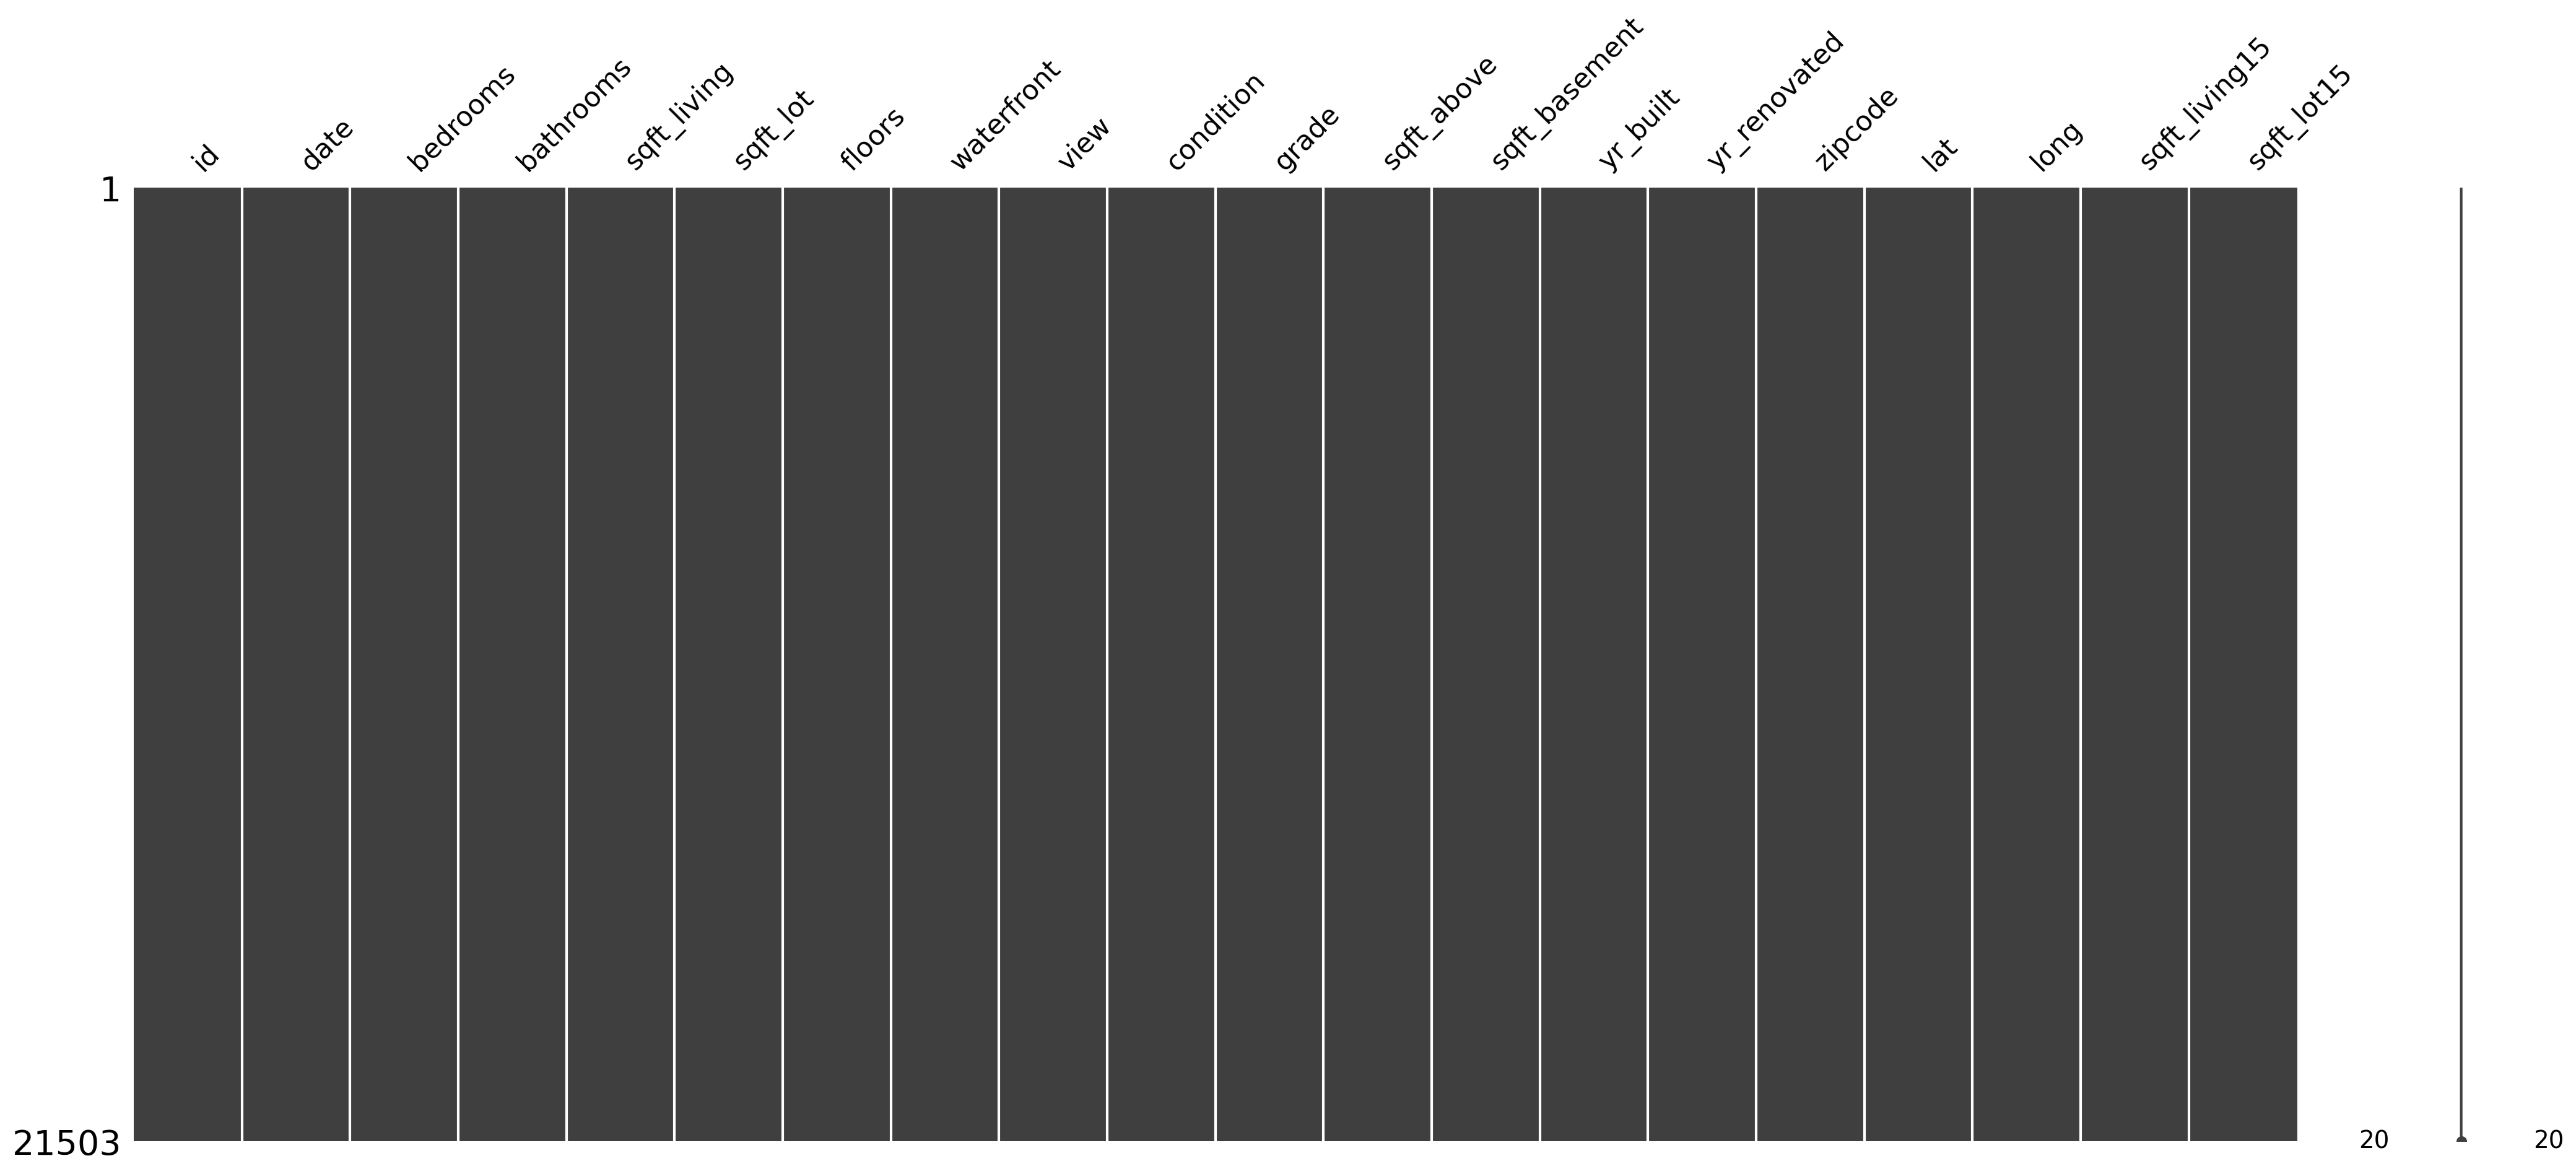

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [9]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

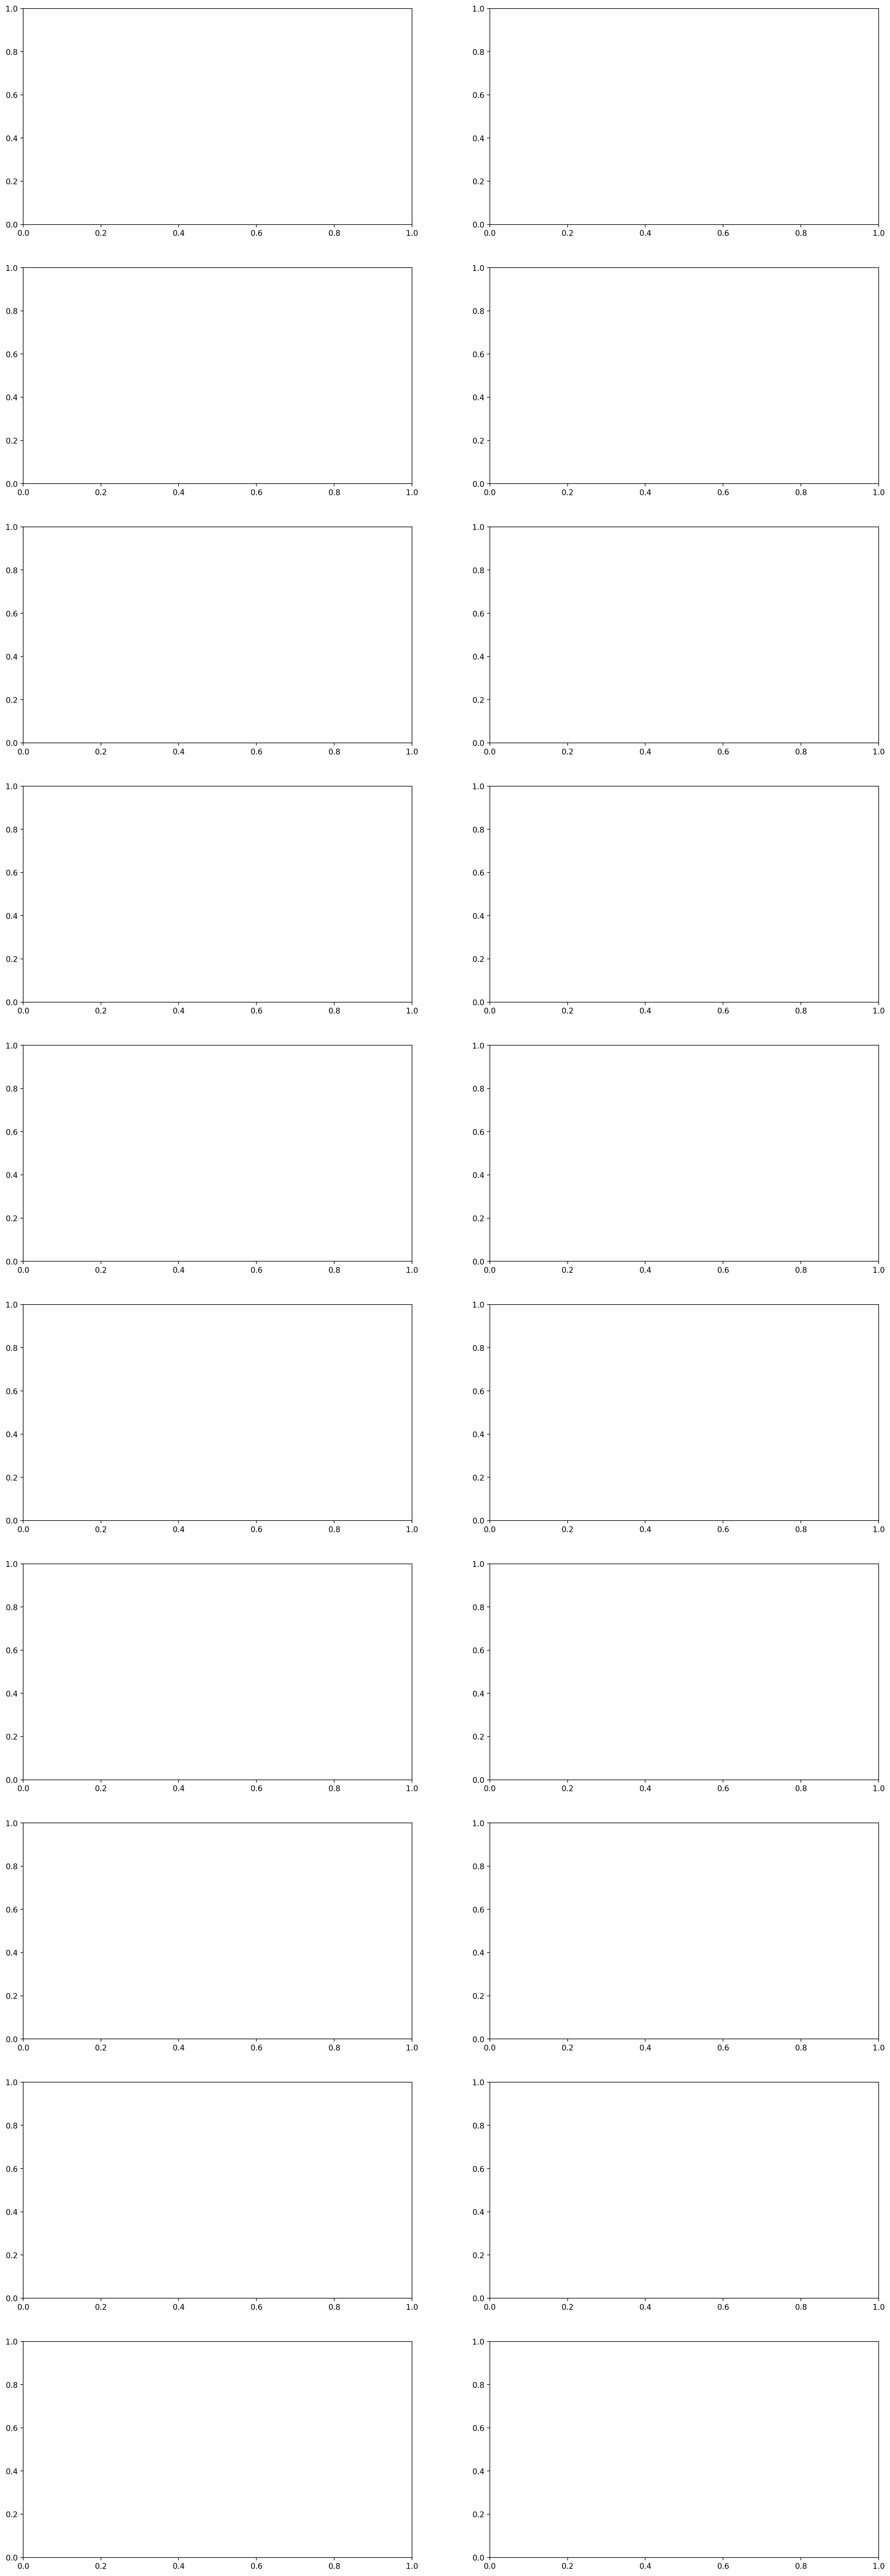

In [10]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [11]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

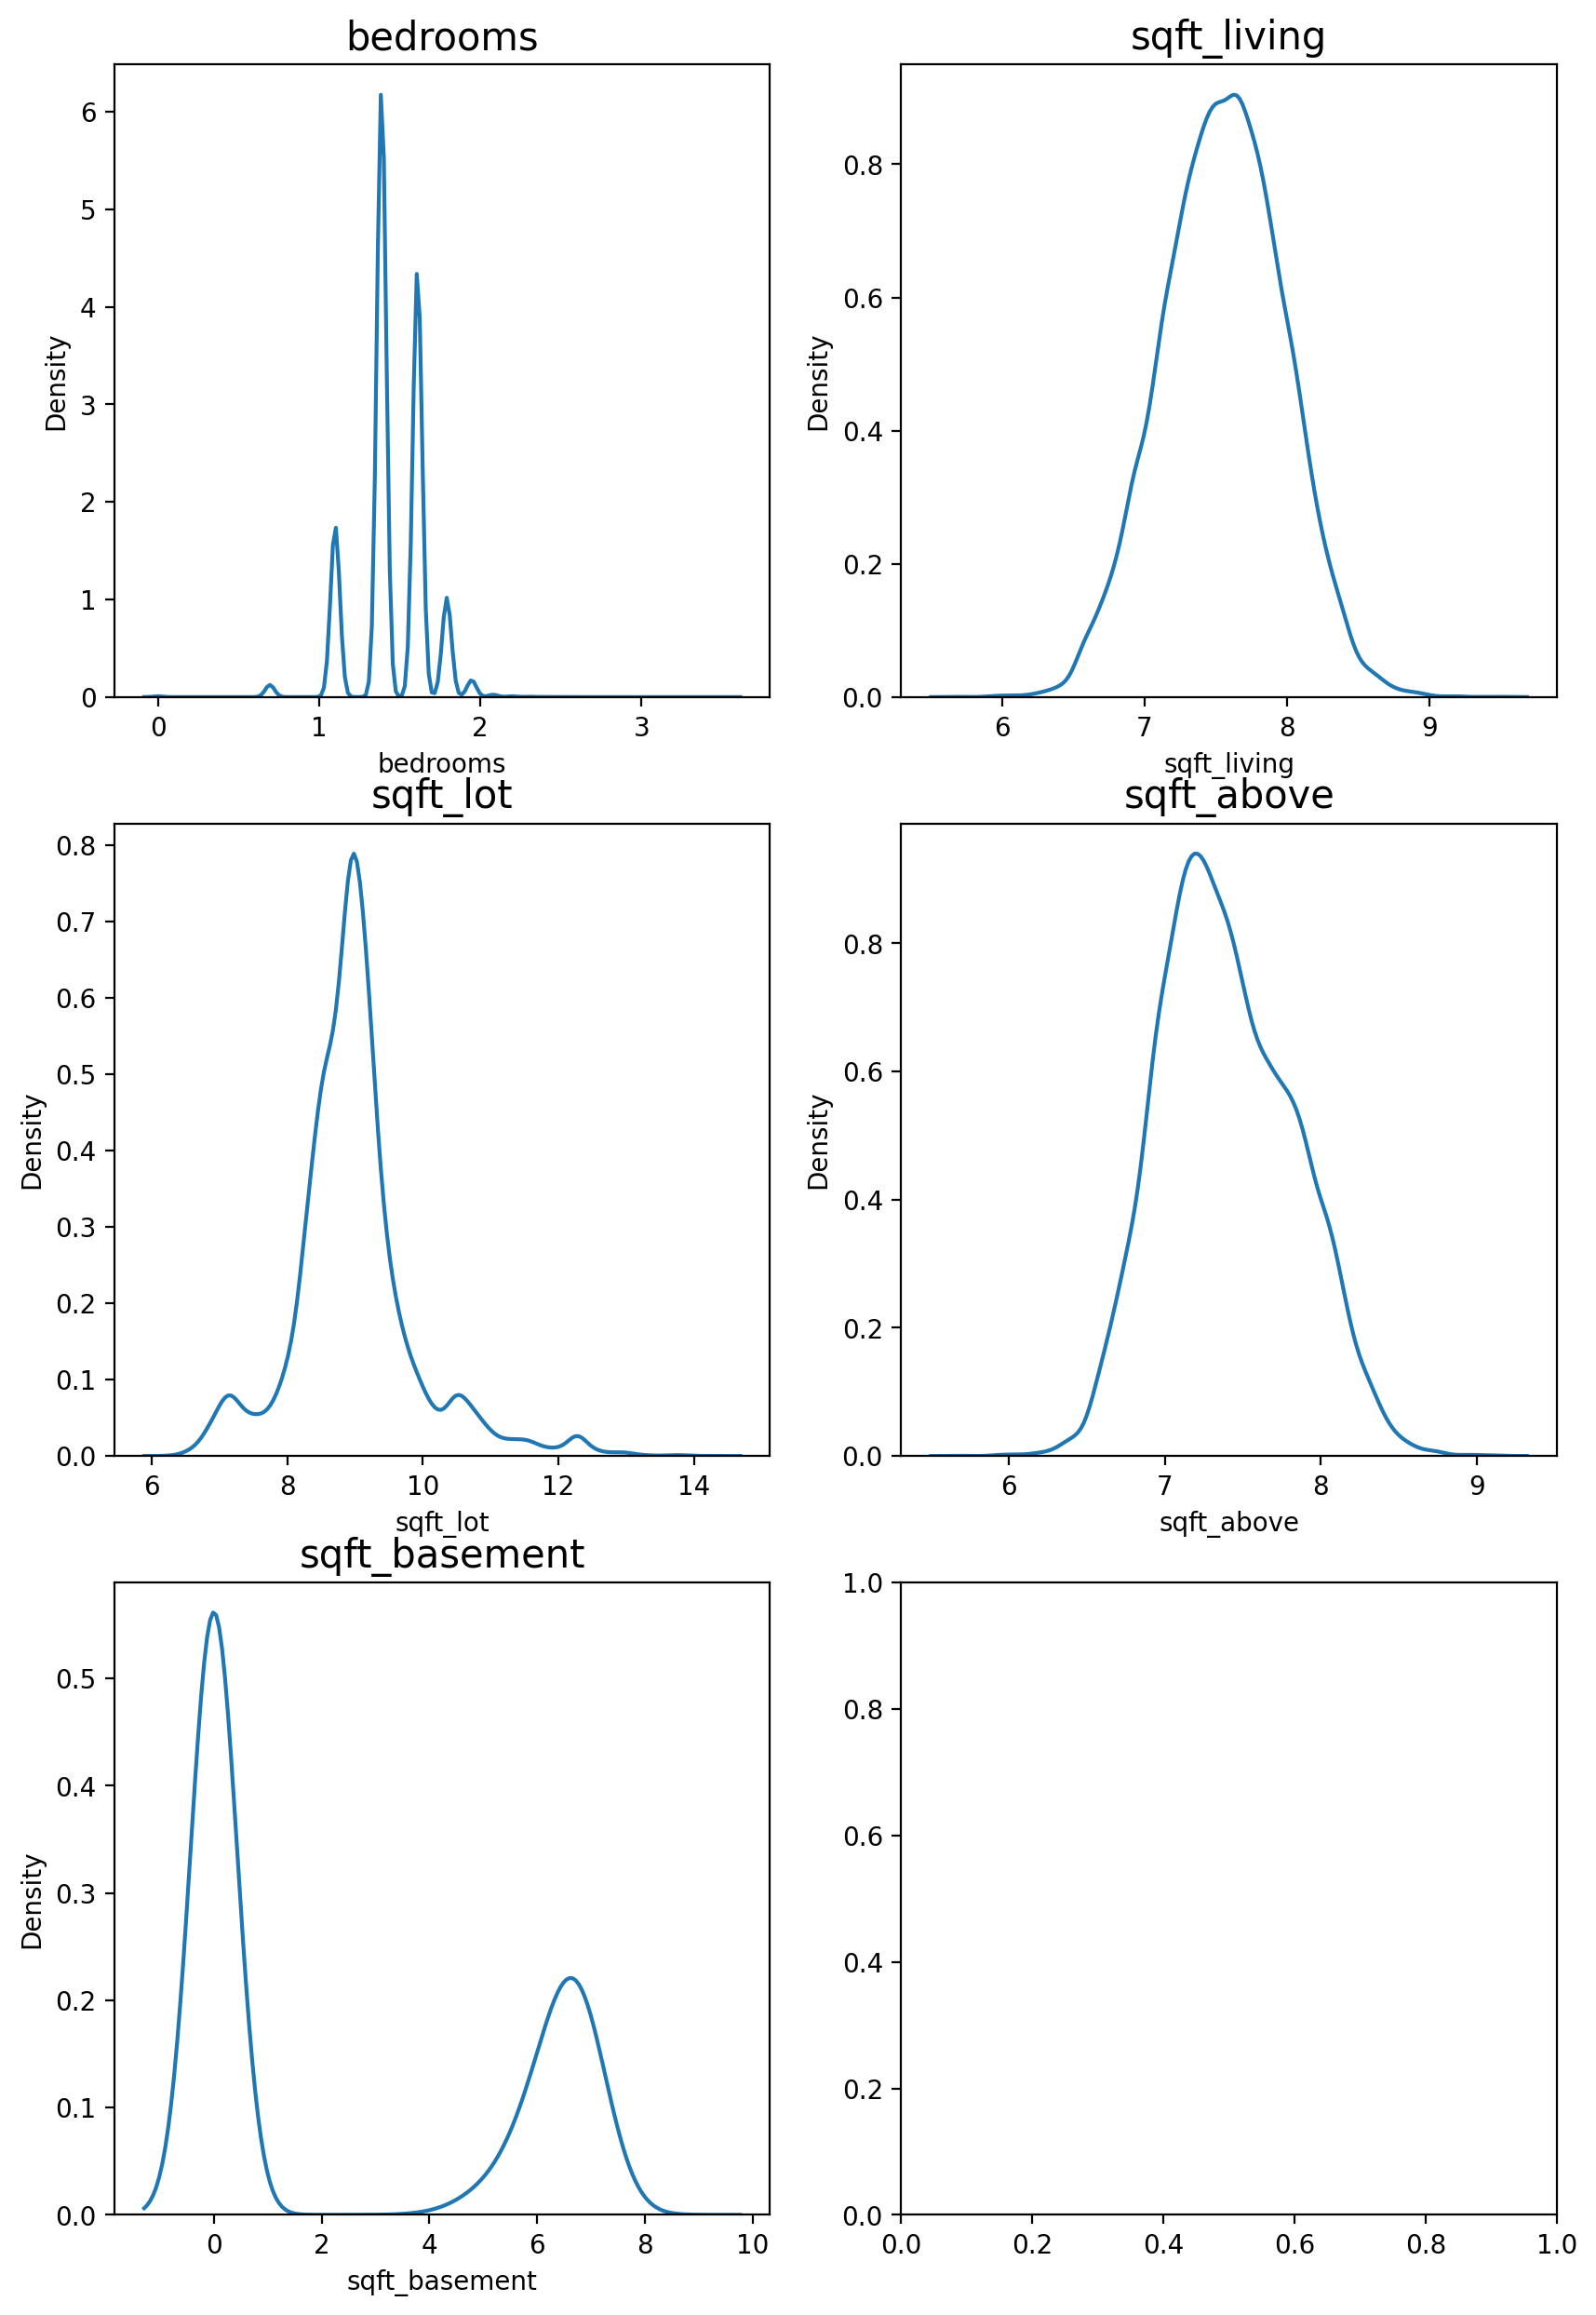

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [13]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [14]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [15]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [16]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8598
Model XGBoost CV score : 0.8861
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
Y

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [17]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [18]:
y_pred = AveragingBlending(models, x, y, sub)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143


In [19]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [20]:
sub.to_csv('submission.csv', index=False)